In [5]:
library(tidyverse)
library(repr)
library(dplyr) 
library(tidymodels)
options(repr.matrix.max.rows = 6)

Session: This is likely collected via an automated system that they embedded within the server.

Variable summary:
There are 5 variables in the sessions.csv. 1535 observations.
| Variable name       | Data type | Description                                 |
| :--------           | :-------  | :---------                                  |
| hashedEmail         | Categorial| User identification via email               |
| start_time          | Date-time | Beginning of a session in dd/mm/yyyy, hh:mm |     
| end_time            | Date-time | End of a session in dd/mm/yyyy, hh:mm       | 
| original_start_time | Numerical | Start time recorded in milliseconds         |
| original_end_time   | Numerical | End time recorded in milliseconds           |

Summary statistics:

Session duration:

|Count	|Mean  | Median |Standard Deviation	 |Variance |	Minimum (hours)	| Maximum (hours) |
|:----  |:---  |:----   |:---- |:----    |:---- |:---   |
|1533	|48.49 |0	    | 79.69|6350.52	 |   0	| 333.33|


Sessions per user: 


|Mean	|Minimum  | Maximum |
|:----  |:---  |:----   |
|12.28	|310 |1	    |


Issues: 
1. There is missing data for end times for rows like 681 and 1019.
2. What constitues a session. Large playtime can be someone genuinely playing or forgetting to close the game. Any trackers of activity built-in?
3. Unknown period of gaming for each individual. Meaning, a player can have 50 sessions and they can all come from within the same month, or someone could have 50 sessions but it's spread out within all 4 months. Session frequency does not really say much on its own. Need to perform more analyses to find out each players' sessions and frequency.
4. High variance. Makes this dataset bad for prediction.


Player: This is likely collected via a combination surveys and an automated system that they embedded within the server.

Variable summary: There are 7 variables in the players.csv. 196 observations

| Variable name       | Data type | Description                                 |From where
| :--------           | :-------  | :---------                                  |:----
| experience         | Categorial| Player skill classification: beginner, amateur, regular, veteran, pro|self-reported|
| subscribe          | Boolean | True or false, whether a player has subscribed to something|      from system|
| hashedEmail            | Categorical| User identification via email| from system| 
| played_hours | Numerical | Hours of gameplay for each player       | from system  |
| name   | Categorical | Name/chosen name of player          |self-reported
| gender   | Categorical | Player's identity         | self-reported |
| age   | Numerical | Players age in years          | self-reported |

Summary statistics:


|Stat	|Age  | played_hours |
|:----  |:---  |:----   |
|Mean	|21.14 |5.85	    |
|Median	|19 |0.1	    |
|Standard Deviation	|7.39 |28.36	    |
|Variance	|54.61 |804.14	    |
|Minimum	|9 |0	    |
|Maximum|58 |223.1	    |

Issues: 
1. There is missing data for ages.
2. Weird outliers. The top 6 highest hours ranges from 53 to 223 hours. These outliers heavily affect the skewedness and thus the data's use in prediction. 
3. Quick scroll through and there are a lot of 0 hours in there. Even spotted a supposed Veteran with 0 hours of playtime (103)
4. Much of the data here appears to be self-reported, which will result in bias and misrepresentation as everyone's definition of each of the 5 classifications would inevitably be different, unless a very specific metric was provided for that specific question. As for the players' ages, they could lie about it and nobody would know unless the survey asked for direct identification. So there is high uncertainty for the reliability of the data.


In [6]:
sessions <- read_csv("data/sessions.csv")
players <- read_csv("data/players.csv")

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
players_hours <- players|>
    select(played_hours)|>
    arrange(desc(played_hours))|>
    slice(1:6)
players_hours #weird outliers

player_age_stats<-players|>
    filter(!is.na(Age))|>
    summarise(
        count = n(),
        mean = round(mean(Age), 2),
        median = round(median(Age), 2),
        sd = round(sd(Age), 2),
        variance = round(var(Age), 2),
        min = round(min(Age),2),
        max = round(max(Age),2))
player_age_stats

player_time_stats<-players|>
    summarise(
        count = n(),
        mean = round(mean(played_hours), 2),
        median = round(median(played_hours), 2),
        sd = round(sd(played_hours), 2),
        variance = round(var(played_hours), 2),
        min = round(min(played_hours),2),
        max = round(max(played_hours),2))
player_time_stats

played_hours
<dbl>
223.1
218.1
178.2
150.0
56.1
53.9


count,mean,median,sd,variance,min,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.14,19,7.39,54.61,9,58


count,mean,median,sd,variance,min,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,5.85,0.1,28.36,804.14,0,223.1


In [8]:
session_stats<-sessions|>
    filter(!is.na(original_end_time))|>
    mutate(session_duration_mins = (original_end_time - original_start_time) / 60000)|>
    summarise(
        count = n(),
        mean = round(mean(session_duration_mins), 2),
        median = round(median(session_duration_mins), 2),
        sd = round(sd(session_duration_mins), 2),
        variance = round(var(session_duration_mins), 2),
        min = round(min(session_duration_mins),2),
        max = round(max(session_duration_mins),2))
session_stats

#check for players with multiple sessions
user_session_count <- sessions|>
    count(hashedEmail, name = "session_count")|>
    arrange(desc(session_count))

head(user_session_count)

mean_sessions_per_user <- sessions |>
    count(hashedEmail, name = "session_count")|>
    summarise(mean = mean(session_count),
              max = max(session_count),
              min = min(session_count))
mean_sessions_per_user

#check for egregious hours
session_duration <- sessions|>
    filter(!is.na(original_end_time))|>
    mutate(session_duration_mins = (original_end_time - original_start_time) / 60000)|>
    arrange(desc(session_duration_mins))|>
    slice(1:6)|>
    select(hashedEmail, start_time, end_time, session_duration_mins)
session_duration

count,mean,median,sd,variance,min,max
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1533,48.49,0,79.69,6350.52,0,333.33


hashedEmail,session_count
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,147
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,130
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,95


mean,max,min
<dbl>,<int>,<int>
12.28,310,1


hashedEmail,start_time,end_time,session_duration_mins
<chr>,<chr>,<chr>,<dbl>
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,30/06/2024 16:21,30/06/2024 20:32,333.3333
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,01/07/2024 21:53,02/07/2024 02:05,333.3333
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,29/08/2024 01:17,29/08/2024 05:32,333.3333
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,03/08/2024 04:59,03/08/2024 09:12,333.3333
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,30/08/2024 21:36,31/08/2024 01:14,333.3333
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,03/08/2024 21:36,04/08/2024 01:51,333.3333


Broad question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Specific question: Can **experience** and **subscription** predict the **total session hours** in the players dataset? 

Method:
Merge the two datasets together, find their played hours based on the sessions dataset since the data in there is within the observation period. To find each player's total sessions, group them by their email and sum up their total sessions' minutes. For that I'd have to convert the UNIX units into minutes. For further insight, maybe I can find how long each players' typical session lasts. Like, when they are subscribed, if they usually do long sessions. 
I would subtract the original_start_time from the original_end_time just to see how much time the player spends on each session, them sum them up to see how much time the player spent on all their sessions in total. And convert it to minutes or even hours because UNIX is unreadable.

Q: Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.

|Stat	|Age  | played_hours |
|:----  |:---  |:----   |
|Mean	|21.14 |5.85	    |

In [9]:
combined_data <- sessions|>
    filter(!is.na(original_end_time))|>
    mutate(session_duration_mins = (original_end_time - original_start_time) / 60000)|>
    group_by(hashedEmail)|>
   summarise(
        total_sessions = n(),
        avg_session_mins = mean(session_duration_mins),
        total_session_mins = sum(session_duration_mins))|>
    left_join(players, by = "hashedEmail")|>
    mutate(total_session_hrs = total_session_mins / 60)|>
    mutate(avg_session_hrs = avg_session_mins / 60)
combined_data
#avg_session_hrs is within the observation period. Use that instead. Not sure about the timeframe of played_hours or what it actually reprsents.    

hashedEmail,total_sessions,avg_session_mins,total_session_mins,experience,subscribe,played_hours,name,gender,Age,total_session_hrs,avg_session_hrs
<chr>,<int>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,83.33333,166.6667,Regular,TRUE,1.5,Isaac,Male,20,2.777778,1.388889
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.00000,0.0000,Pro,FALSE,0.4,Lyra,Male,21,0.000000,0.000000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.00000,0.0000,Beginner,TRUE,0.1,Osiris,Male,17,0.000000,0.000000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310,16.12903,5000.0000,Amateur,TRUE,56.1,Dana,Male,23,83.333333,0.2688172
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.00000,0.0000,Amateur,TRUE,0.1,Fatima,Male,17,0.000000,0.0000000
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,166.66667,166.6667,Beginner,TRUE,1.1,Caden,Male,20,2.777778,2.7777778


In [18]:
nrow(combined_data)

[1] 125

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


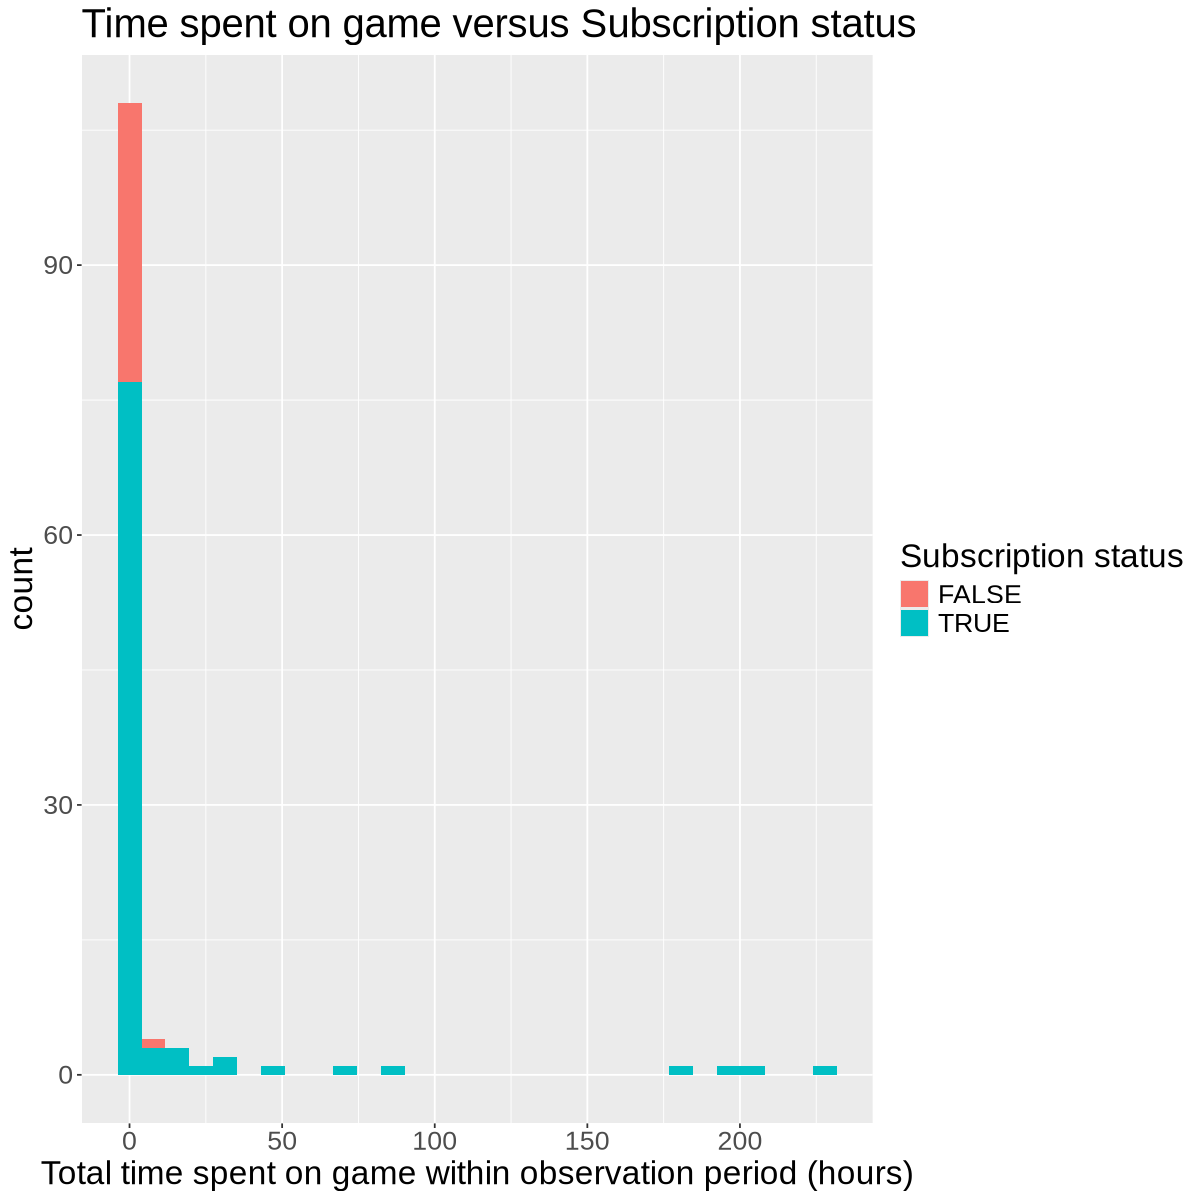

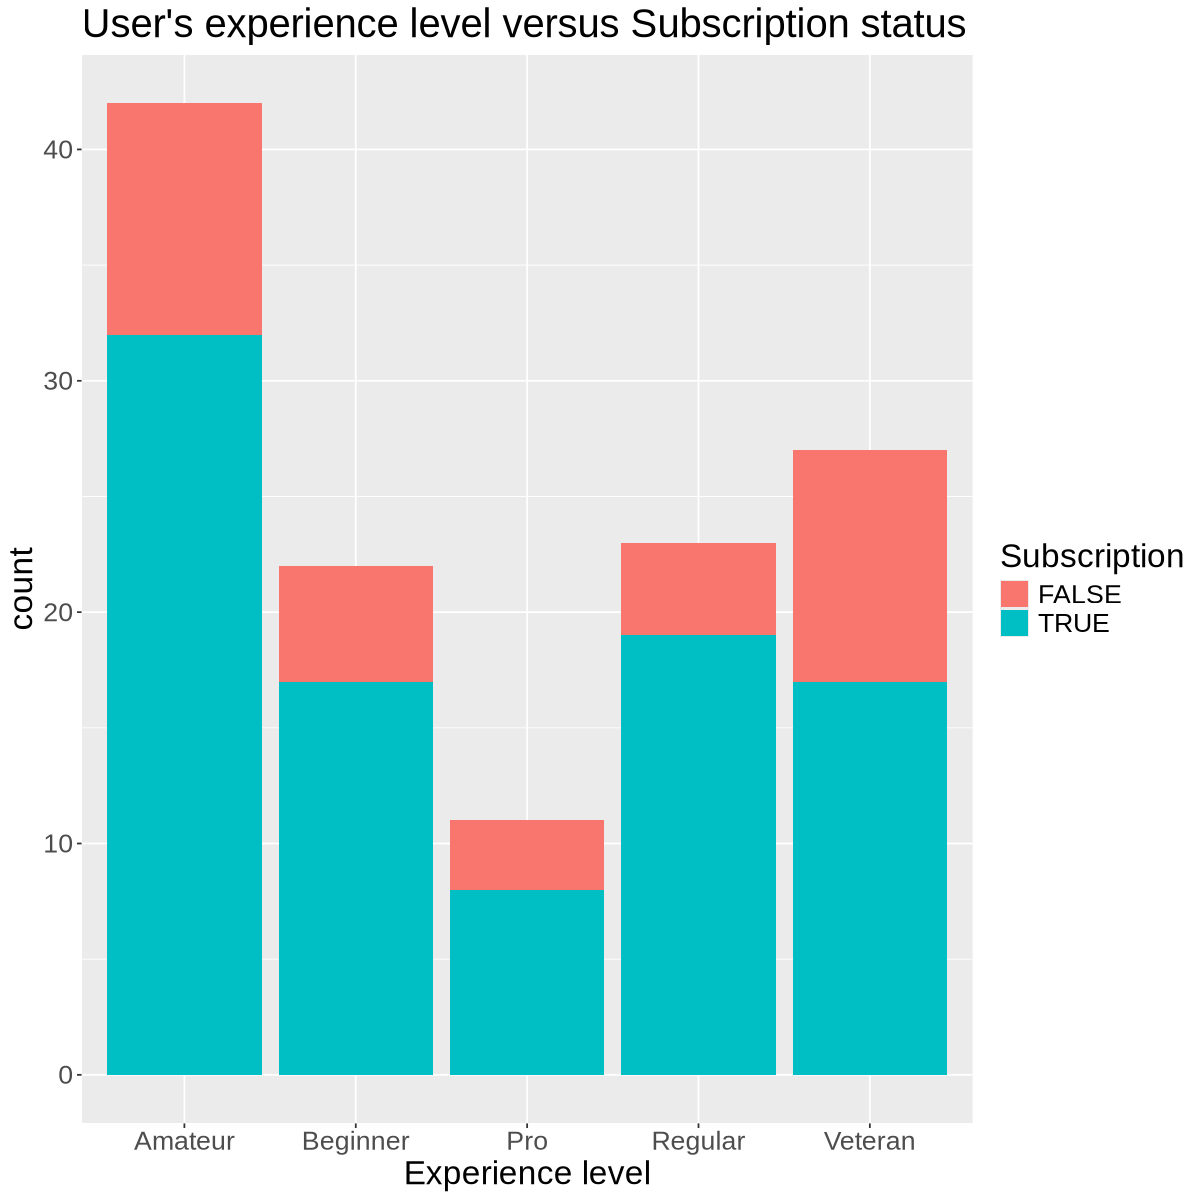

hashedEmail,total_sessions,avg_session_mins,total_session_mins,experience,subscribe,played_hours,name,gender,Age,total_session_hrs,avg_session_hrs
<chr>,<int>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,83.33333,166.6667,Regular,TRUE,1.5,Isaac,Male,20,2.777778,1.388889
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.00000,0.0000,Pro,FALSE,0.4,Lyra,Male,21,0.000000,0.000000
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.00000,0.0000,Beginner,TRUE,0.1,Osiris,Male,17,0.000000,0.000000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,1,166.6667,166.6667,Pro,TRUE,1.2,Sakura,Male,17,2.777778,2.777778
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,1,0.0000,0.0000,Amateur,TRUE,0.1,Fatima,Male,17,0.000000,0.000000
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1,166.6667,166.6667,Beginner,TRUE,1.1,Caden,Male,20,2.777778,2.777778


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


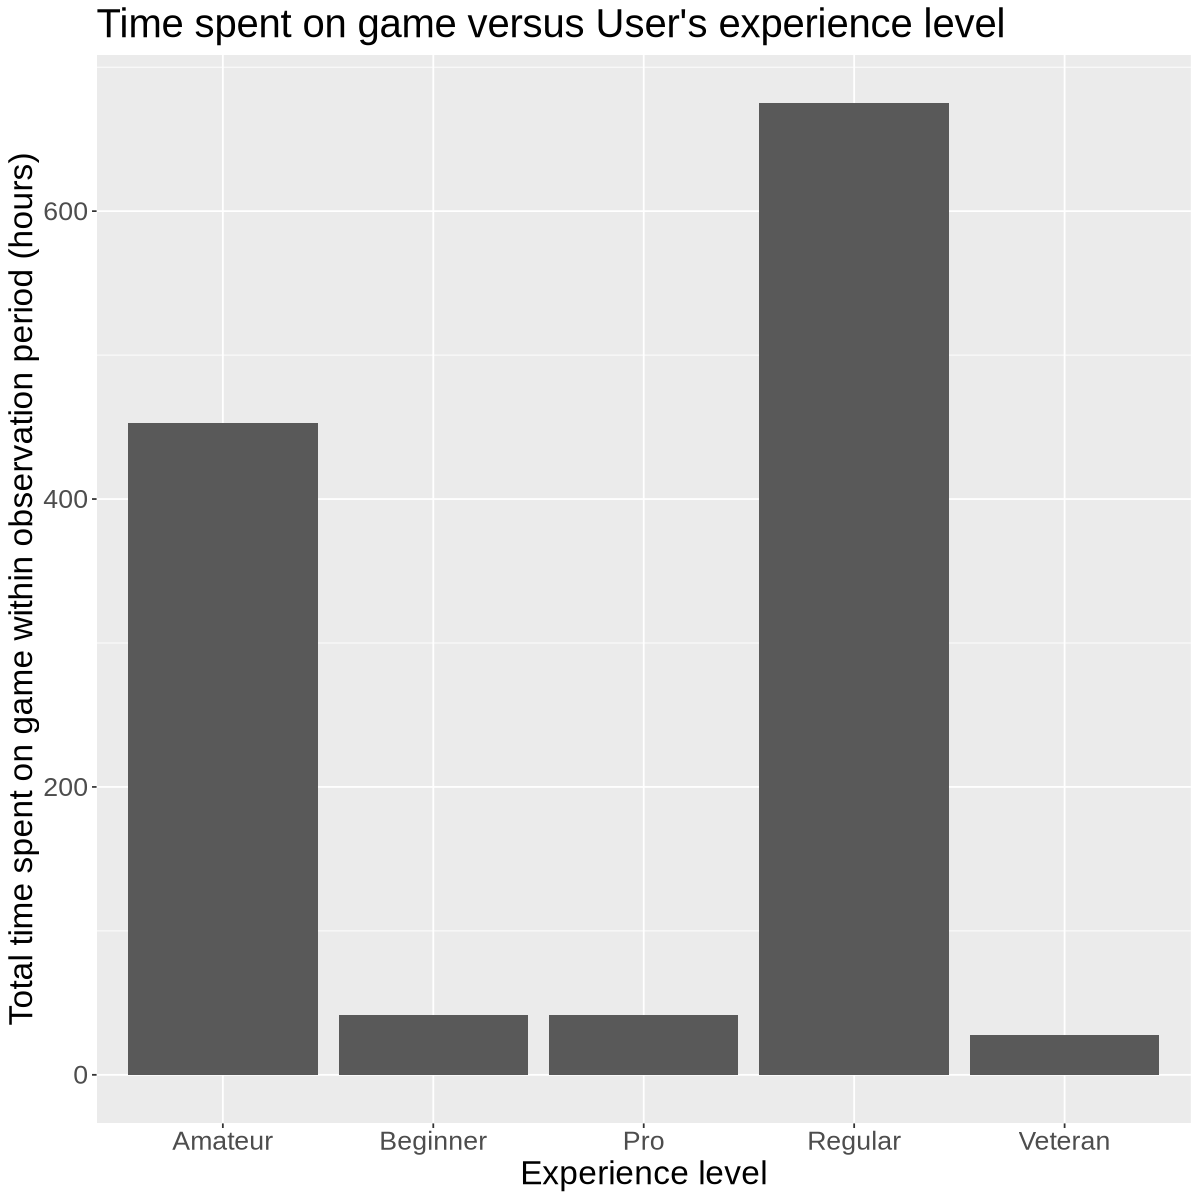

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


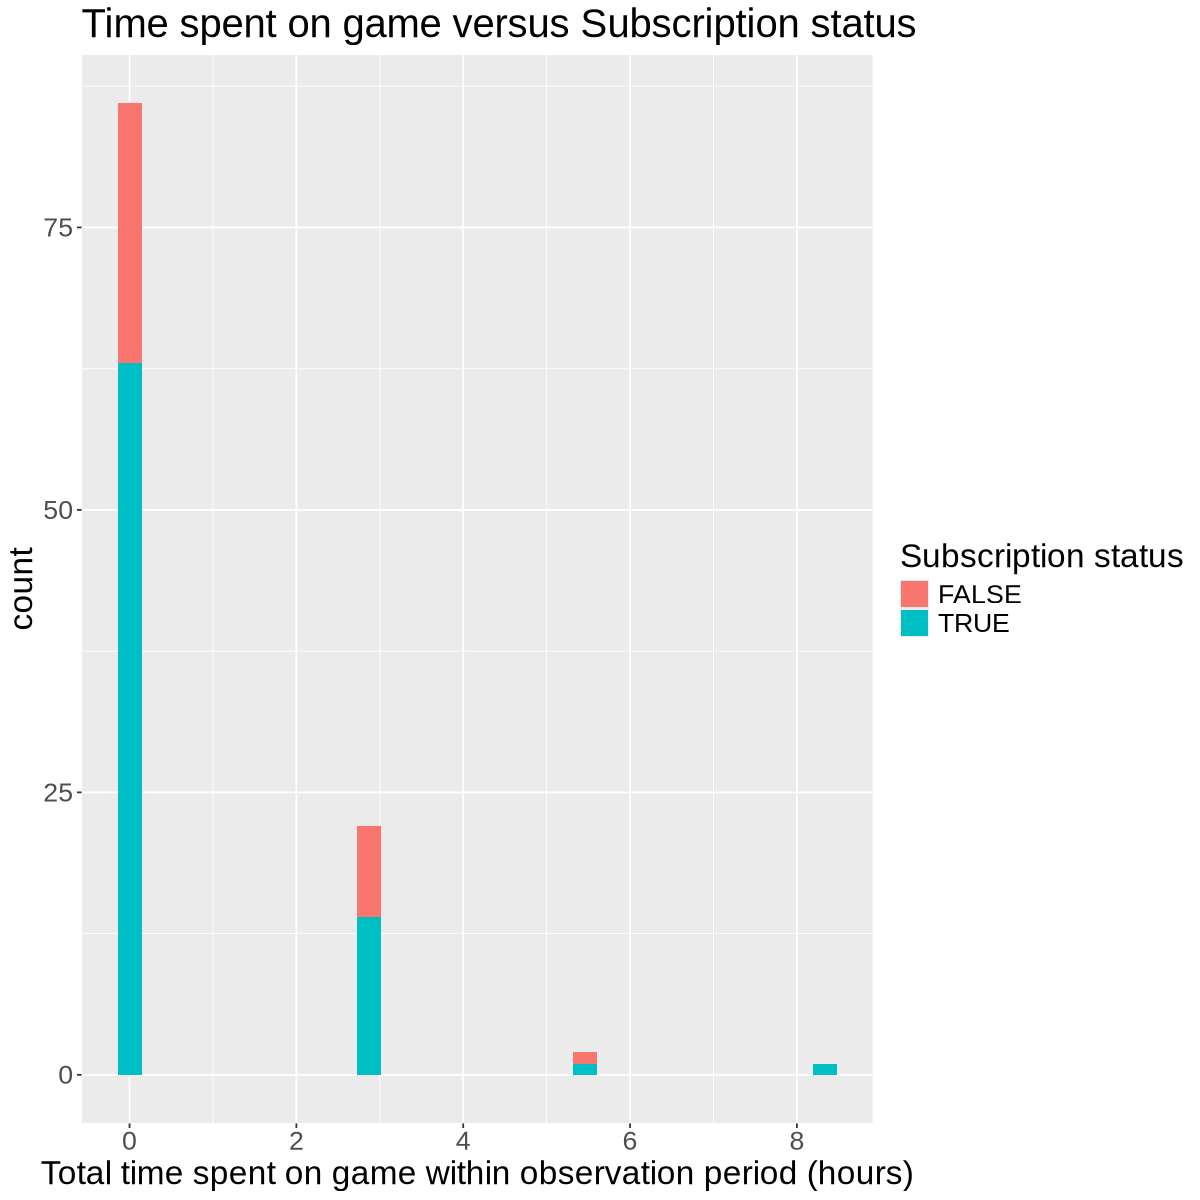

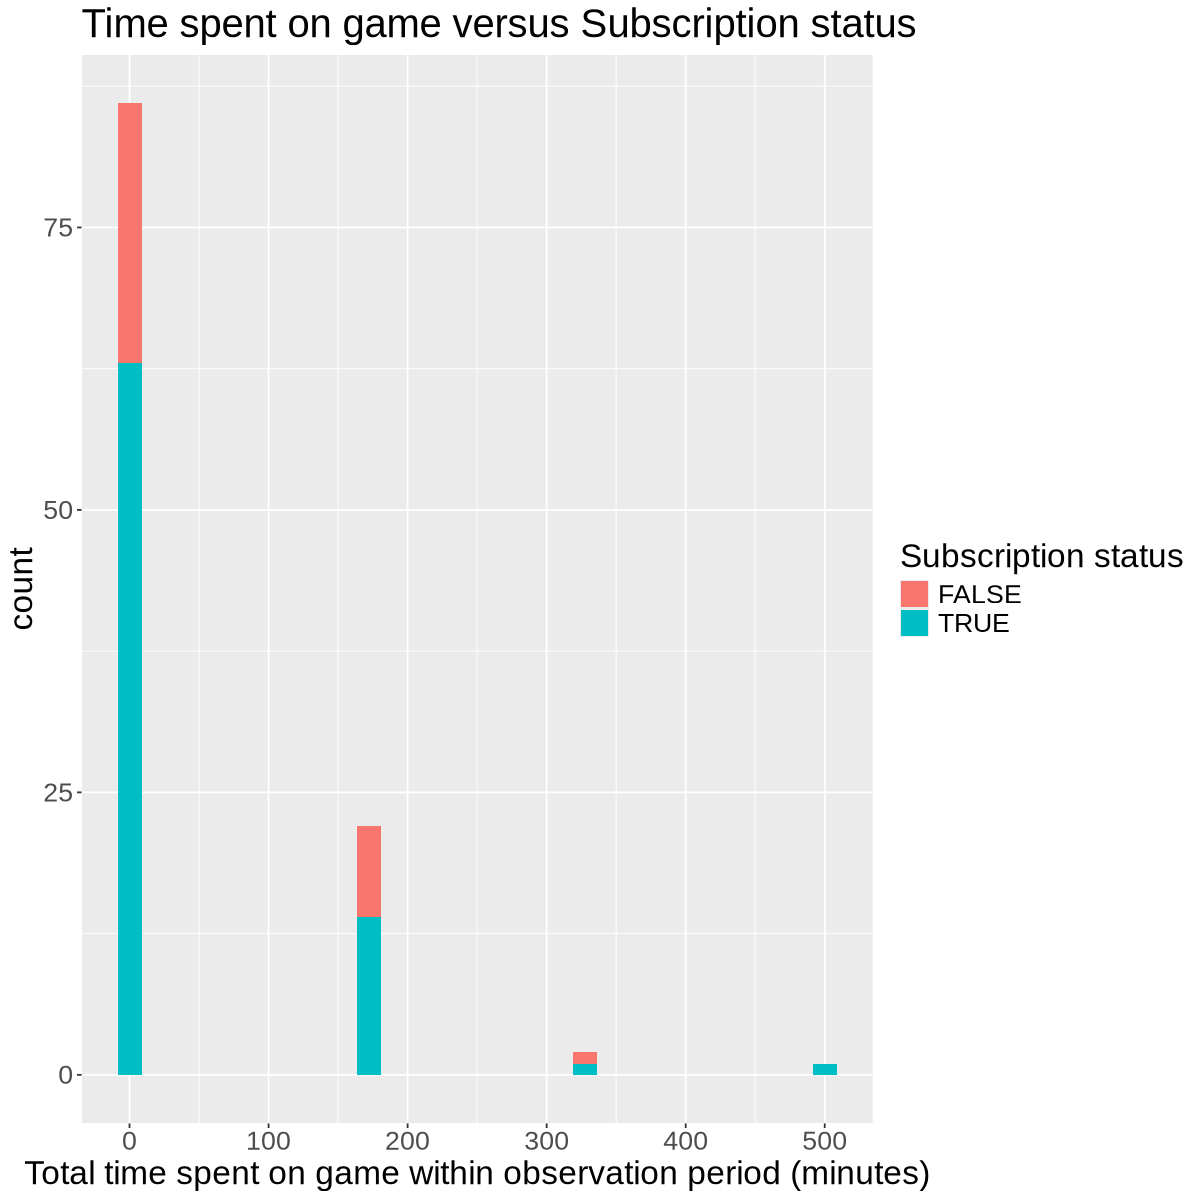

In [10]:
options(repr.plot.height = 10, repr.plot.width = 10)

time_vs_sub_plot <- combined_data|>
    ggplot(aes(x = total_session_hrs, fill = subscribe))+
    geom_histogram()+
    labs(x = "Total time spent on game within observation period (hours)", fill = "Subscription status")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game versus Subscription status")
time_vs_sub_plot

class_vs_sub_plot <- combined_data |>
     ggplot(aes(x = experience, fill = subscribe))+
    geom_bar()+
    labs(x = "Experience level", fill = "Subscription")+
    theme(text = element_text(size = 20))+
    ggtitle("User's experience level versus Subscription status")
class_vs_sub_plot

time_vs_class_plot <- combined_data |>
    ggplot(aes(x = experience, y = total_session_hrs))+
    geom_bar(stat="identity")+
    labs(x = "Experience level", y = "Total time spent on game within observation period (hours)")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game versus User's experience level")
time_vs_class_plot

cd_filtered <- combined_data|>
    filter(total_session_hrs <= 10)|>
    filter(total_session_mins <= 500)
cd_filtered

time_vs_sub_plot2 <- cd_filtered|>
    ggplot(aes(x = total_session_hrs, fill = subscribe))+
    geom_histogram()+
    labs(x = "Total time spent on game within observation period (hours)", fill = "Subscription status")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game versus Subscription status")
time_vs_sub_plot2


time_vs_sub_plot3 <- cd_filtered|>
    ggplot(aes(x = total_session_mins, fill = subscribe))+
    geom_histogram()+
    labs(x = "Total time spent on game within observation period (minutes)", fill = "Subscription status")+
    theme(text = element_text(size = 20))+
    ggtitle("Time spent on game versus Subscription status")
time_vs_sub_plot3

From the time vs experience, I can infer that the experience level is likely self-declared because of how irregular the data appears. Usually, people with the most hours spent would be of veteran status and least be of beginner status. So this might not be a very reliable metric of measurement to find a target audience, since it is very likely to be biased. 

But, in the context of the question itself, this bias also might not be too big of a concern because we are finding a target audience. If they choose to declare themselves as something based on their own experiences, we can just target that and it'll still be fine. (Need to refine this is office hours, I have no idea how to word it)

I made a second version of the time vs sub plot because of the outliers making the data hard to read (and also I thought I was misreading things when majority of the data was at 0 hours), and since all outliers appear to have been subscribed, anyway. However, there seems to be a jarring count of people who spent 0 minutes on the game and still subscribed. I looked back at the sessions data, and I saw that a lot of the original_start_time and original_end_time data points are exactly the same, making their difference 0. This might indicate I would need to shift over to working with the start_time and end_time data by converting the ddmmyyhhmm time into straight minutes or seconds in order for this analysis to work. Or if even that doesn't work, I'll have to scrape the idea of a combined dataset and use played_hours from the players dataset instead.

It appears that no matter what skill level the player has, the people who have subscribed will always be larger in numbers than those who haven't. So I was right to not make one of these predict the other. 

There also is a small relationship between those who subscribed vs their play time, despite the graph not being able to tell much since the majority of players happen to lie at 0 minutes. I took to making a table instead, and the total session hours for those who have subscribed is 1183.33 hours higher than whose who didn't. So, subscription should actually work if we want to predict how many hours people spend on the game in total. So, the more hours spent, the more likely they are to get a subscription, whatever the subscription includes.

In [11]:
subscribed_players <- combined_data|>
    group_by(subscribe)|>
    summarise(
        count = n(),
        total_sesh_hrs = round(sum(total_session_hrs, na.rm = TRUE), 2))|>
    mutate(percentage_of_subscription = round(count/sum(count) *100, 2))
subscribed_players

subscribe,count,total_sesh_hrs,percentage_of_subscription
<lgl>,<int>,<dbl>,<dbl>
FALSE,32,27.78,25.6
TRUE,93,1211.11,74.4


Linear regression. 
The response variable is numeric and continuous, so linear regression is the best option so far. And since I'm measuring how much one thing affects another, the equation for the straight line can directly describe the relationship between the predictors and the response variable. I'd need to assume the relationship between the predictors and response variable is linear, though. I would also need to assume that the observations are independent. Since each row should be a different player with the way I combined the data, it should be independent. 

Limitations include over generalising each category of player. By that I mean a "Regular" might not have exactly X amount of hours played more than a "Amateur". And the labels here, after reading the graph, don't exactly make much sense to the bigger Minecraft scene anyway since typically you'd expect pros or veterans to have more hours than the rest, but this may be outside the scope of this project. So it is very heavy on assuming linearity. There are also some missing values for the original_end_time in the sessions dataset. 

I will be splitting the data into a training and testing set with a 70-30 split. Will be splitting it at the very start. I will also do cross-validation to ensure accuracy and its predictive performance, to avoid the need of a validation set. 
I can try this with knn-regression too, since it also predicts continuous variables. The biggest difference is that it doesn't assume linearity. Which is also good since it allows for more flexibility and adaptability, allowing it to handle any unexpected strange relationships in the data. But its overall interpretability might be not so great because if I ask something like "How many hours do pros play more than beginners?" the answer would be "it depends", which is not ideal if I my goal is to know who to target in recuitment efforts. That aside, I can use that model to see how the results differ from assuming linearity. To compare their accuracy, I should compare their rmse. The lower one would be more accurate, but I'd also need to take into consideration the practical use of each model based on the question I want to answer despite their accuracy.